This notebook demonstrates performance of RNN model. It also saves/loads some data and figures. Model's parameters can be changed in the corresponding sections here.

In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter 

import pathlib
import pickle
import IPython.display as display

%matplotlib inline 

In [3]:
# rnn model
from src.rnn import data, model, train

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.electricity as electricity_data

## Data preprocessing

In [4]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
color_list = ['#7F27FF', '#FF8911', '#65B741']

In [5]:
# names of observed signals
sig_names = ['Production program', 'Price']
# measure units
sig_units = ['MhW', 'TL']

num_signals = 2

In [6]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = electricity_data.GetTrainTestData(
    series_len=3000,
    test_ratio=0.18
)

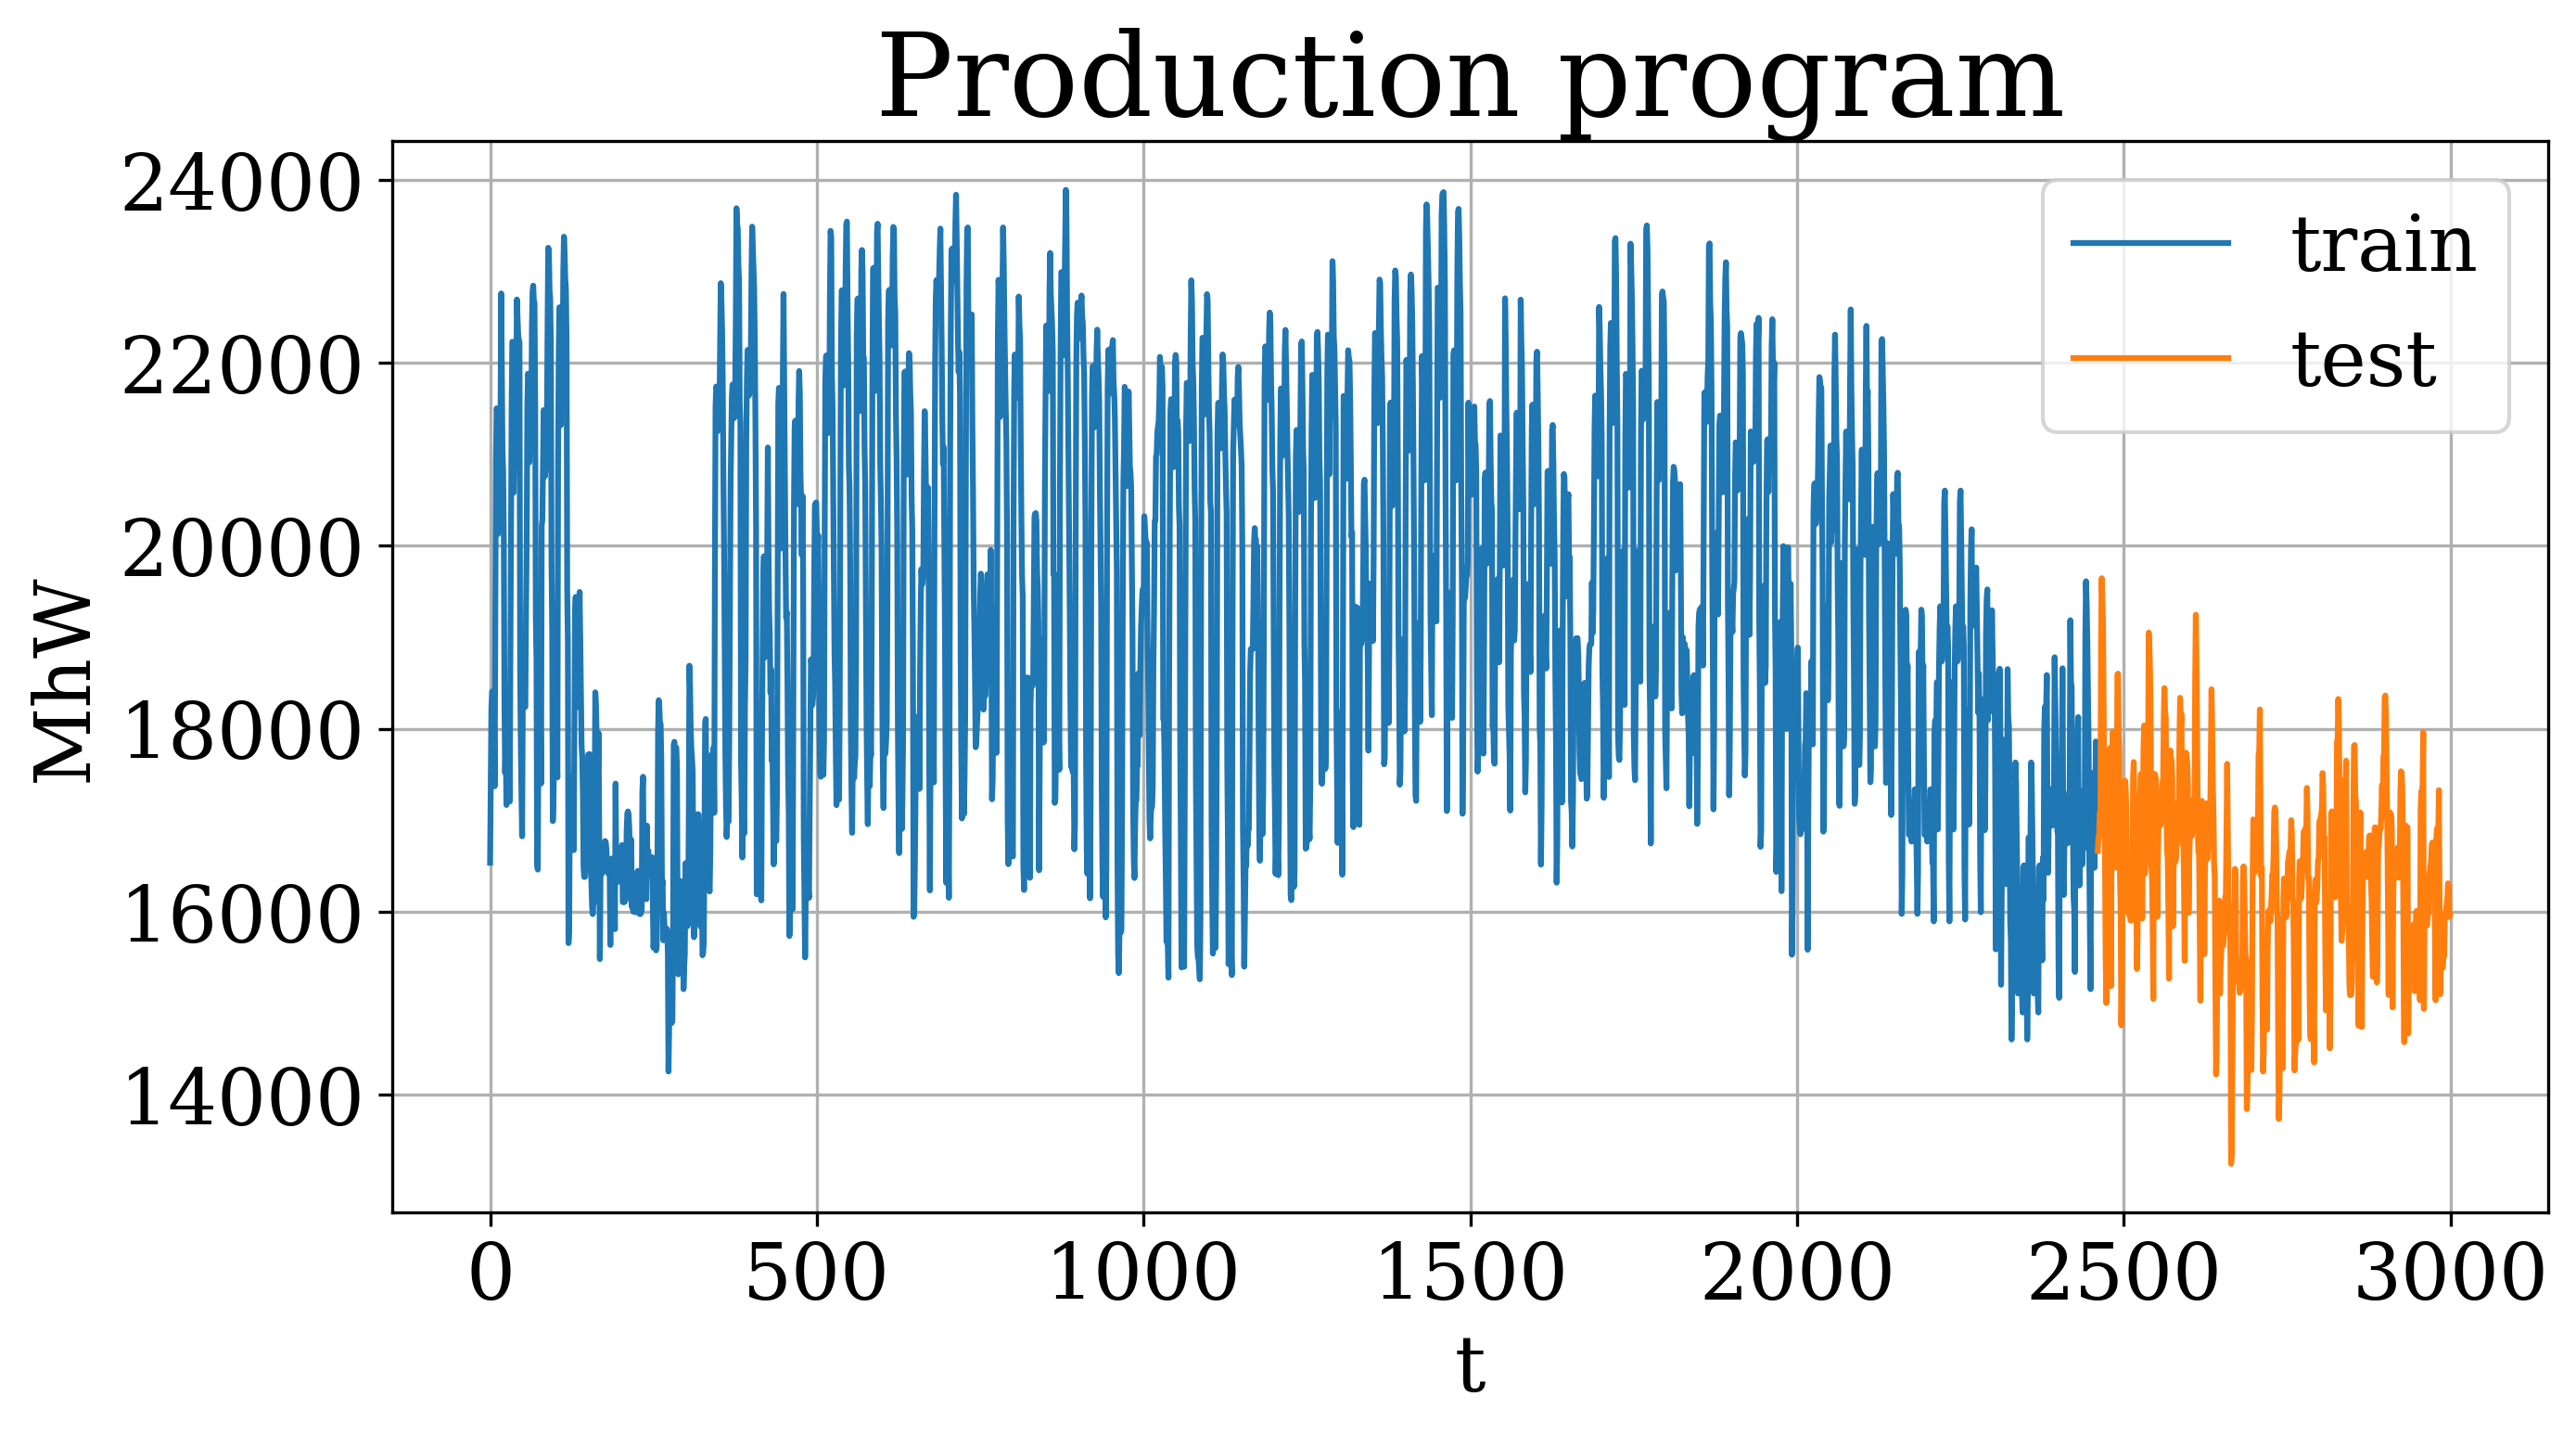

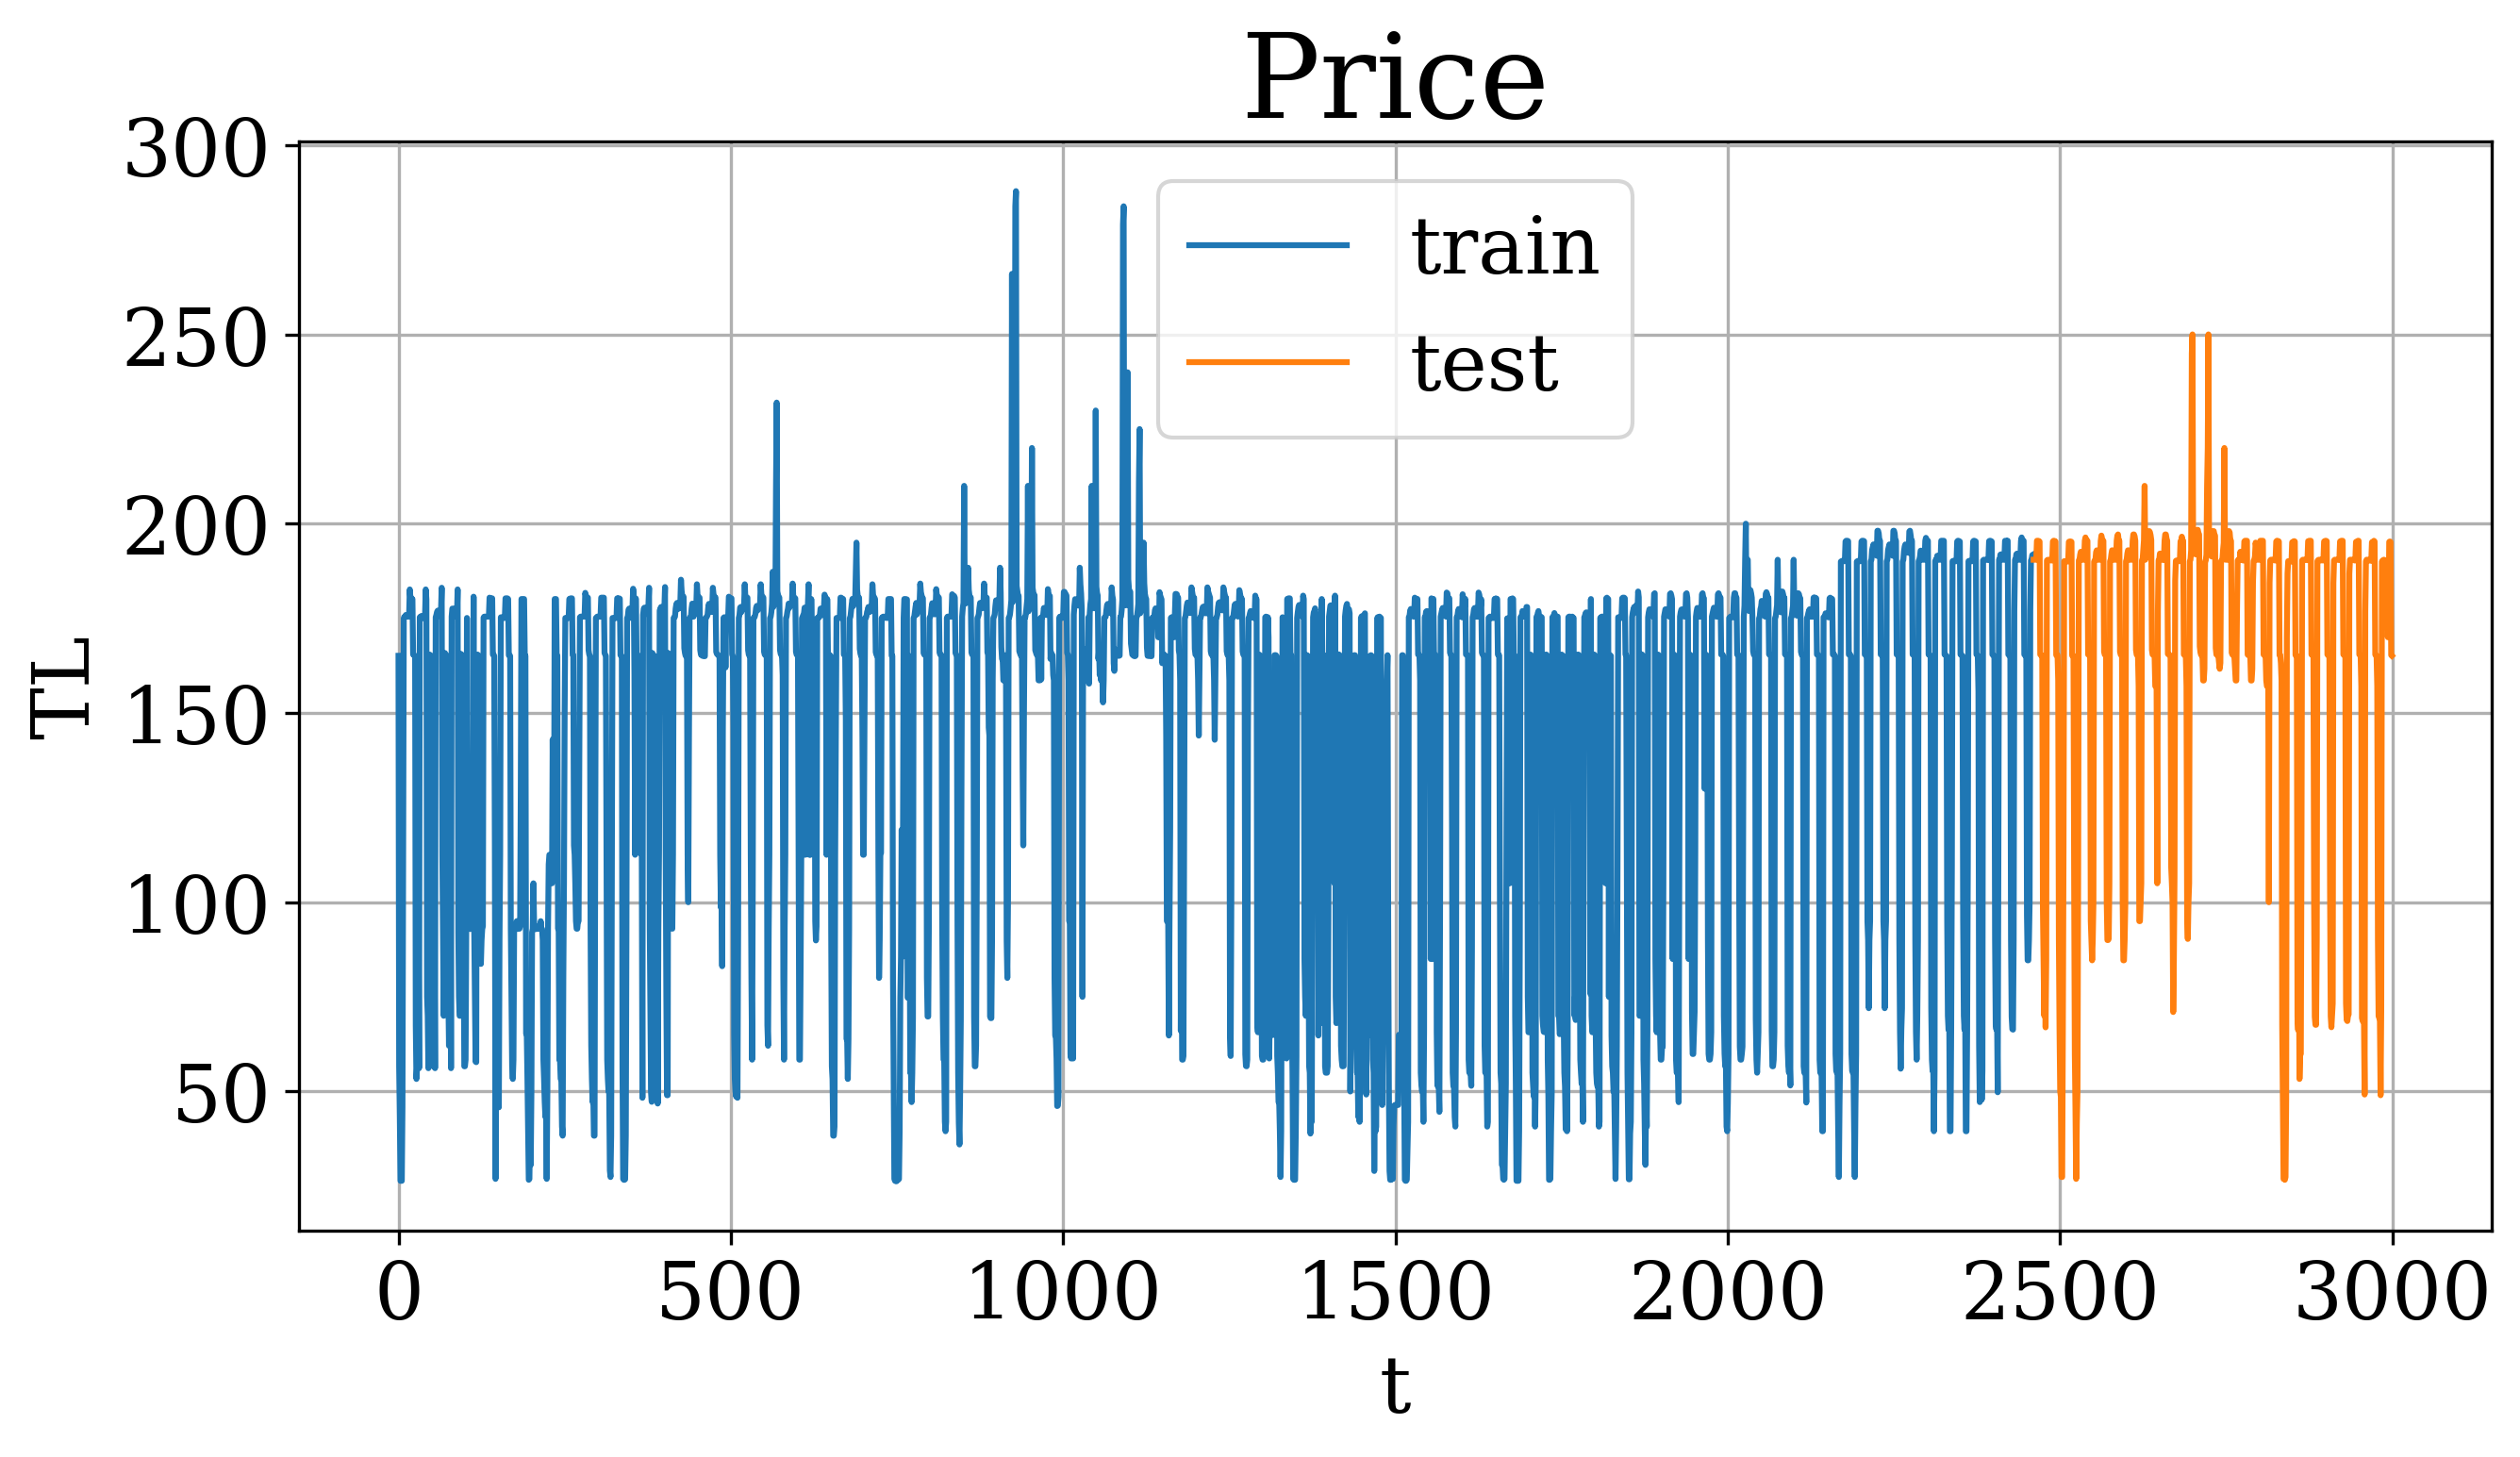

In [7]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

In [8]:
# normalize data
train_mean = train_data.mean()
train_std = train_data.std()

test_mean = test_data.mean()
test_std = test_data.std()

train_data = (train_data - train_mean) / train_std
test_data = (test_data - test_mean) / test_std

In [7]:
# L parameter, for consitency across models in paper
window_size = 500

In [10]:
batch_size = 64
num_samples = 1000

# get slices from the time series (may overspan) and build dataset out of it
# length of the slices is set to be window_size
train_loader = data.GetTrainDataloader(
    train_time_series=train_data,
    len_in_batch=window_size,
    num_samples=num_samples,
    batch_size=batch_size
)

## Experiment

In [8]:
torch.cuda.empty_cache()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
# create folders for model backup and metrics
pathlib.Path(f'./backup').mkdir(exist_ok=True, parents=True)
pathlib.Path(f'./tensorboard').mkdir(exist_ok=True, parents=True)

Create rnn predicter model

In [13]:
input_dim = train_data.shape[1]
hidden_dim = 100
num_layers = 1

rnn_predictor = model.RnnSignalPredictor(
    input_dim,
    hidden_dim,
    num_layers
).to(device=device)

Tune other train parameters

In [14]:
log_writer = SummaryWriter(f'./tensorboard')

In [15]:
optimizer =torch.optim.Adam(rnn_predictor.parameters(), lr=0.01)

In [16]:
num_epochs = 101
batches_per_epoch = int(0.4 * num_samples) // batch_size + 1

backup_frequency = 50

In [17]:
for epoch_num in range(num_epochs):
    # train model
    epoch_losses = train.TrainEpoch(
        train_loader,
        rnn_predictor,
        optimizer,
        batches_per_epoch,
        device
    )

    # safe epoch loss
    for i in range(len(epoch_losses)):
        log_writer.add_scalar(
            'Train/MSE',
            epoch_losses[i].item(),
            epoch_num * batches_per_epoch + i
        )

    # backup model
    if epoch_num % backup_frequency == 0:
        train.BackupModel(
            rnn_predictor,
            f'./backup/rnn_predictor.pkl'
        )

    # compute metrics on test
    mse, mape = train.EvaluatePredictor(
        torch.from_numpy(train_data[-window_size:].copy()).to(dtype=torch.float32),
        torch.from_numpy(test_data).to(dtype=torch.float32),
        rnn_predictor,
        device=device
    )

    # safe metircs
    log_writer.add_scalar(
            'Test/MSE',
            mse,
            epoch_num
        )
    log_writer.add_scalar(
            'Test/MAPE',
            mape,
            epoch_num
        )
    
    log_writer.flush()

    # debug
    display.clear_output()
    display.display(f'Epoch {epoch_num}: last loss = {epoch_losses[-1]}; mse, mape on test = {(mse, mape)}')

'Epoch 100: last loss = 0.0035008725244551897; mse, mape on test = (0.00853564590215683, 0.055553846061229706)'

In [18]:
log_writer.close()

### Prediction

In [19]:
# get prediction
rnn_forecast = None

rnn_predictor.eval()

with torch.no_grad():
    test_len = test_data.shape[0]

    # get last series values
    context = torch.from_numpy(train_data[-window_size:].copy()).to(dtype=torch.float32)
    # add batch dim to context and put it on device
    context = context.unsqueeze(0).to(device=device)

    # obtain predictions
    rnn_forecast = rnn_predictor.predict(test_len, context)
    # remove batch dimension and put it on kernal
    rnn_forecast = rnn_forecast.squeeze(0).to(device='cpu').numpy()

In [20]:
# make reverse data transformation
rnn_forecast = rnn_forecast * test_std + test_mean
test_data = test_data * test_std + test_mean

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


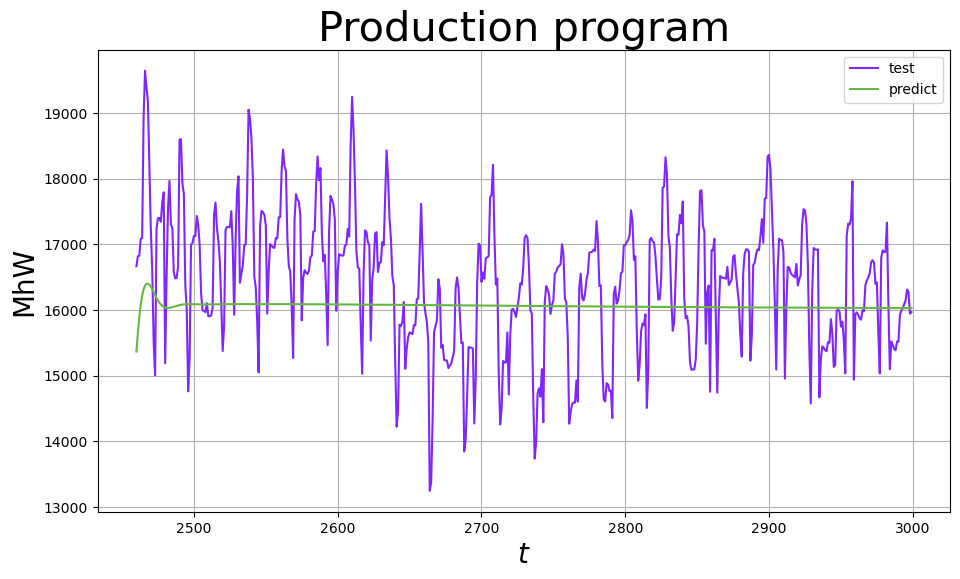

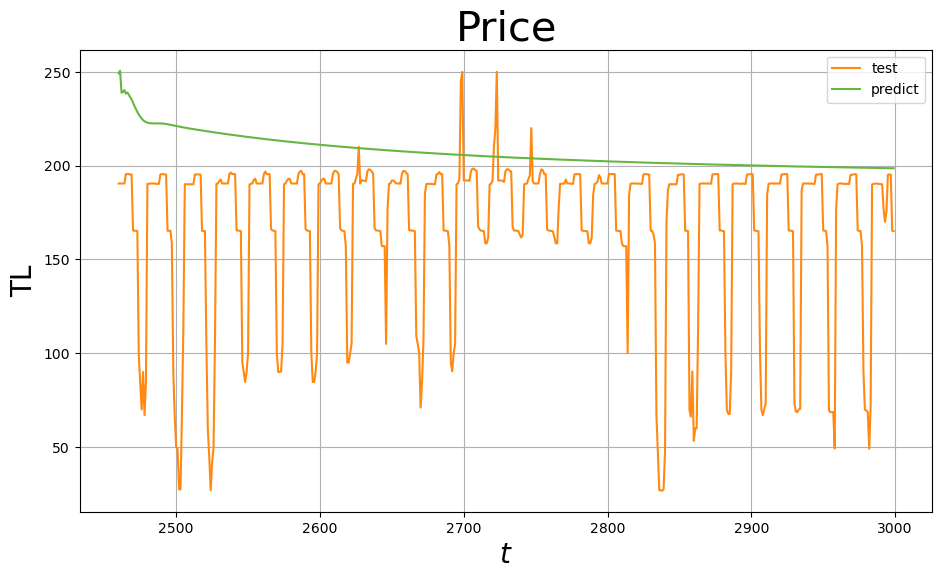

In [21]:
# plot prediction and real values
for i in range(test_data.shape[1]):
    fig, ax = plt.subplots(figsize=(11, 6))

    ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
    ax.plot(time_grid_test, rnn_forecast.T[i], color=color_list[-1], label='predict')

    ax.grid(True)
    ax.legend();
    ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
    ax.set_xlabel('$t$', fontsize=20)
    ax.set_title(f'{sig_names[i]}', fontsize=30)

    fig.savefig(f'./figs/prediction/{sig_names[i].replace(" ", "_")}.eps',
                             format='eps')

In [9]:
with open("./backup/rnn_predictor.pkl", "rb") as f:
    rnn_predictor = pickle.load(f)

rnn_predictor = rnn_predictor.to(device="cpu")

In [10]:
# compute metrics
rnn_mse_metric, rnn_mape_metric = train.EvaluatePredictor(
        torch.from_numpy(train_data[-window_size:].copy()).to(dtype=torch.float32),
        torch.from_numpy(test_data).to(dtype=torch.float32),
        rnn_predictor,
        device="cpu"
    )

print(f'MSE = {rnn_mse_metric}\nMAPE = {rnn_mape_metric}')

# create dataframe for metrics
metrics_frame = pd.DataFrame({'MSE': [rnn_mse_metric], 'MAPE': [rnn_mape_metric]}, index=['VAR']).to_csv()

MSE = [2.7083718e+08 3.0036375e+04]
MAPE = [0.99985754 1.0043428 ]
